In [1158]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import random
import statistics
import sys
import secrets
from scipy.spatial.distance import cdist
import math
import pandas as pd
import warnings
from sklearn.metrics import log_loss, accuracy_score
warnings.filterwarnings('ignore')

In [1179]:
class Kmeans:
    class Point:
        def __init__(self, x, y) -> None:
            self.point = (x, y)
            self.centroid = None

    class Centroid:
        def __init__(self, x, y, label) -> None:
            self.coordinate = (x, y)
            self.points = []
            self.label = label
        
        def update(self, x, y):
            self.coordinate = (x, y)

    def __init__(self, k:int, data) -> None:
        self.centroids = self.get_centroids(data, k)

        self.points = [self.Point(point[0], point[1]) for point in data[:]]

    def get_centroids(self, data, num_centroids):
        min_x, max_x = (data[:, 0].min(), data[:, 0].max())
        min_y, max_y = (data[:, 1].min(), data[:, 1].max())
        centroids = []
        for index in range(num_centroids):
           random_point = tuple(data[np.random.choice(data.shape[0])])
           centroids.append(self.Centroid(random_point[0], random_point[1], index))

        return centroids
    
    def get_objective(self):
        objective = 0
        for centroid in self.centroids:
            coordinate_np = np.array(centroid.coordinate)
            for point in centroid.points:
                diff = np.array(point.point) - coordinate_np

                objective += np.linalg.norm(diff, ord=2)
        return objective

    def train(self, epochs):
        pre_objective = 1
        post_objective = 0
        while round(pre_objective, 3) != round(post_objective, 3):
            pre_objective = post_objective
            for centroid in self.centroids:
                centroid.points = []

            for point in self.points:
                distances = []
                for index, centroid in enumerate(self.centroids):
                    dist = cdist([point.point], [centroid.coordinate])[0][0]
                    distances.append(dist)
                argmin = distances.index(min(distances))

                point.centroid = self.centroids[argmin] # For plotting purposes only
                self.centroids[argmin].points.append(point)
                
            for centroid in self.centroids:
                point_coordinates = np.array([point.point for point in centroid.points])
                new_x, new_y = (point_coordinates[:, 0].mean(), point_coordinates[:, 1].mean())
                centroid.update(new_x, new_y)
            post_objective = self.get_objective()
            
                

In [1160]:
class GMM:
    class Point:
        def __init__(self, x, y, k) -> None:
            self.point = (x, y)
            self.centroid = None
            self.probabilities = [0]*k
            self.label = None

    class Centroid:
        def __init__(self, x, y, mean, covariance, weight, label) -> None:
            self.mean = mean
            self.covariance = covariance
            self.weight = weight

            self.coordinate = (x, y)
            self.points = []
            self.label = label
        
        def update(self, x, y):
            self.coordinate = (x, y)

    def __init__(self, k:int, data) -> None:
        self.k = k
        self.centroids = self.get_centroids(data, k)
        self.cluster_weights = [1.0/k]*k

        self.points = [self.Point(point[0], point[1], k) for point in data[:]]

    def get_centroids(self, data, num_centroids):
        min_x, max_x = (data[:, 0].min(), data[:, 0].max())
        min_y, max_y = (data[:, 1].min(), data[:, 1].max())
        centroids = []

        rng = np.random.default_rng()

        for index in range(num_centroids):
           x_random = rng.uniform(min_x, max_x)
           y_random = rng.uniform(min_y, max_y)
           mean = rng.choice(data)
        #    cov_scale = 1
        #    covariance = [[cov_scale*rng.random(),cov_scale*rng.random()],
        #                  [cov_scale*rng.random(),cov_scale*rng.random()]]
           covariance = np.cov(data.T)
           centroids.append(self.Centroid(x_random, y_random, mean, covariance, 1.0/num_centroids, index))

        return centroids
    
    def e_step(self):
        self.assign_probabilities()
        point_weights_per_cluster = [[] for _ in self.cluster_weights]
        for point in self.points:
            for index, prob in enumerate(point.probabilities):
                point_weights_per_cluster[index].append(prob)

        for index, _ in enumerate(self.cluster_weights):
            cluster_probability = np.mean(point_weights_per_cluster[index])
            self.cluster_weights[index] = cluster_probability

    def m_step(self):
        summed_weights = [[] for _ in range(self.k)]
        point_locations = [[] for _ in range(2)]
    
        for point in self.points:
            for index, prob in enumerate(point.probabilities):
                summed_weights[index].append(prob)
        
            point_locations[0].append(point.point[0])
            point_locations[1].append(point.point[1])

        summed_weights_np = np.array(summed_weights).T
        point_locations_np = np.array(point_locations).T

        cluster_assignments = []
        for row in summed_weights_np:
            cluster_assignments.append(row.argmax())
        
        cluster_assignments = np.array(cluster_assignments)
        cluster_indexes = []
        for cluster_idx in range(self.k):
            cluster_indexes.append(np.where(cluster_assignments == cluster_idx)[0])

        for index, _ in enumerate(self.cluster_weights):
            total = summed_weights_np[:, index].sum()
            cluster = self.centroids[index]

            x_mean = (point_locations_np[:, 0] * summed_weights_np[:, index]).sum()/total
            y_mean = (point_locations_np[:, 1] * summed_weights_np[:, index]).sum()/total

            cluster_points = point_locations_np[cluster_indexes[index]]
            cluster_weights = summed_weights_np[cluster_indexes[index]] 

            cluster.mean = (x_mean, y_mean)
            cluster.covariance = np.cov(cluster_points.T, aweights=(cluster_weights[:, index]/total), bias=True)


    def assign_probabilities(self):
        for index, centroid in enumerate(self.centroids):
            np_cov = self.safe_covariance(centroid.covariance)

            dist = stats.multivariate_normal(centroid.mean, np_cov)
            for point in self.points:
                point.probabilities[index] = self.cluster_weights[index] * dist.pdf([point.point[0], point.point[1]])

        for point in self.points:
            total_prob = sum(point.probabilities)
            for index, prob in enumerate(point.probabilities):
                point.probabilities[index] = prob/total_prob
                point.label = point.probabilities.index(max(point.probabilities))
                
    def safe_covariance(self, cov):
        np_cov = np.array(cov)
        min_eig = np.min(np.real(np.linalg.eigvals(np_cov)))
        if min_eig < 0:
            np_cov -= min_eig * np.eye(*np_cov.shape)
        return np_cov

    def get_probabilities(self, point):
        probabilities = []
        for index, centroid in enumerate(self.centroids):
            np_cov = self.safe_covariance(centroid.covariance)
            dist = stats.multivariate_normal(centroid.mean, np_cov)

            probabilities.append(self.cluster_weights[index] * dist.pdf([point.point[0], point.point[1]]))
            total_prob = sum(probabilities)

            for index, prob in enumerate(probabilities):
                probabilities[index] = prob/total_prob

        return probabilities

    def predict(self, point):
        weights = self.get_probabilities(point)
        return weights.index(max(weights))
    
    def train(self, epochs):
        for _ in range(epochs):
            self.e_step()
            self.m_step()

    def get_loss(self, means):
        truth = []
        for index, centroid in enumerate(self.centroids):
            centroid_distances = []
            for mean in means:
                dist = cdist([mean], [centroid.mean])[0][0]
                centroid_distances.append(dist)
            truth.extend([np.argmin(centroid_distances)]*100)
        
        preds = [point.probabilities for point in self.points]

        return log_loss(truth, preds, labels=[0,1,2]) 

In [1161]:
def generate_data(sigma = 1):
    p_a = ([-1, -1], sigma * np.array([[2, 0.5], [0.5, 1]]))
    p_b = ([1, -1], sigma * np.array([[1, -0.5], [-0.5, 2]]))
    p_c = ([0, 1], sigma * np.array([[1, 0], [0, 2]]))

    clusters = [p_a, p_b, p_c]

    labels = [*([0]*100), *([1]*100), *([2]*100)]

    points = [] 
    
    points_a = stats.multivariate_normal(p_a[0], p_a[1]).rvs(100)
    points_b = stats.multivariate_normal(p_b[0], p_b[1]).rvs(100)
    points_c = stats.multivariate_normal(p_c[0], p_c[1]).rvs(100)

    mean_a = (np.mean(points_a[:, 0]), np.mean(points_a[:, 1]))
    mean_b = (np.mean(points_b[:, 0]), np.mean(points_b[:, 1]))
    mean_c = (np.mean(points_c[:, 0]), np.mean(points_c[:, 1]))

    means = (mean_a, mean_b, mean_c)

    points.extend(points_a)
    points.extend(points_b)
    points.extend(points_c)

    return np.array(points), clusters, labels, means


In [1162]:
def get_kmeans_accuracy(kmeans, means):
    distances = []
    labels = []
    for index, centroid in enumerate(kmeans.centroids):
        centroid_distances = []
        for mean in means:
            dist = cdist([mean], [centroid.coordinate])[0][0]
            centroid_distances.append(dist)
        labels.extend([np.argmin(centroid_distances)]*100)

    predicted = [point.centroid.label for point in kmeans.points]

    return accuracy_score(labels, predicted)

In [1163]:
def get_gmm_accuracy(gmm, means):
    distances = []
    labels = []
    for index, centroid in enumerate(gmm.centroids):
        centroid_distances = []
        for mean in means:
            dist = cdist([mean], [centroid.mean])[0][0]
            centroid_distances.append(dist)
        labels.extend([np.argmin(centroid_distances)]*100)

    predicted = [point.label for point in gmm.points]

    return accuracy_score(labels, predicted)

In [1164]:
sigmas = [0.5, 1, 2, 4, 8]

0.9262552623761416


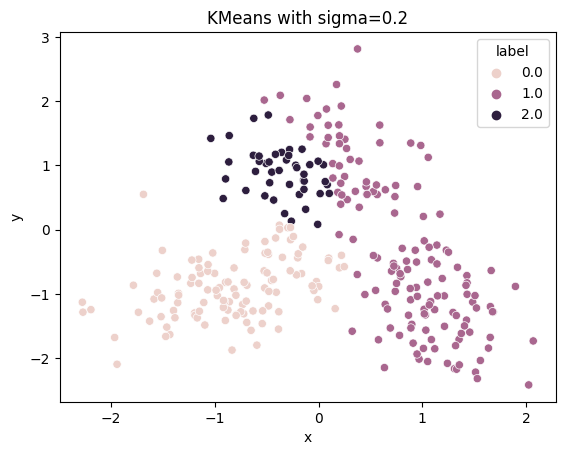

In [1165]:
data, clusters, labels, means = generate_data(0.2)
gmm = GMM(3, data)
gmm.train(10)
print(gmm.get_loss(means))

get_gmm_accuracy(gmm, means)

clustered_data = [[point.point[0], point.point[1], point.label] for point in gmm.points]
np_clustered = np.array(clustered_data)
clustered_pd = pd.DataFrame(np_clustered, columns=["x", "y", "label"])
sns.scatterplot(data=clustered_pd, x="x", y="y", hue="label")
plt.title(f"KMeans with sigma=0.2") 
plt.show()

In [1205]:
plot_loss = []
plot_accuracy = []
for sigma in sigmas:
    model_eval = []
    for _ in range(10):
        data, clusters, labels, means = generate_data(sigma)
        kmeans = Kmeans(3, data)
        kmeans.train(10)
        model_eval.append((kmeans.get_objective(), get_kmeans_accuracy(kmeans, means)))

        # clustered_data = [[point.point[0], point.point[1], point.centroid.label] for point in kmeans.points]
        # np_clustered = np.array(clustered_data)
        # clustered_pd = pd.DataFrame(np_clustered, columns=["x", "y", "label"])
        # sns.scatterplot(data=clustered_pd, x="x", y="y", hue="label")
        # plt.title(f"KMeans with sigma={sigma}") 
        # plt.show()
    plot_loss.append((sigma, max(model_eval, key = lambda x: x[1])[0]))
    plot_accuracy.append((sigma, max(model_eval, key = lambda x: x[1])[1]))

print(plot_loss)
print(plot_accuracy)
plot_loss = np.array(plot_loss)
plot_accuracy = np.array(plot_accuracy)

[(0.5, 270.8615375391588), (1, 339.1642016566013), (2, 469.04989708515967), (4, 664.1862974033847), (8, 925.6155933274862)]
[(0.5, 0.8533333333333334), (1, 0.7166666666666667), (2, 0.6533333333333333), (4, 0.57), (8, 0.5366666666666666)]


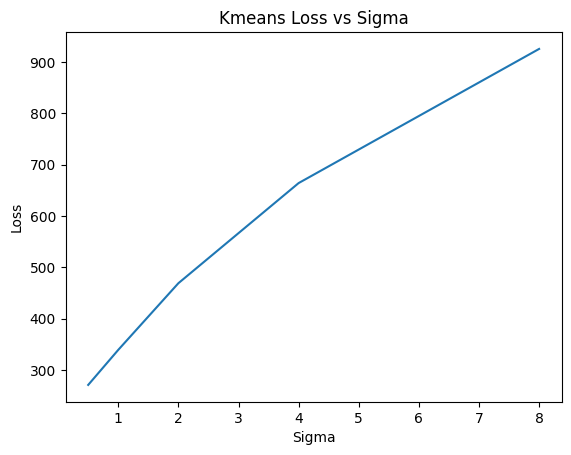

Text(0, 0.5, 'Accuracy')

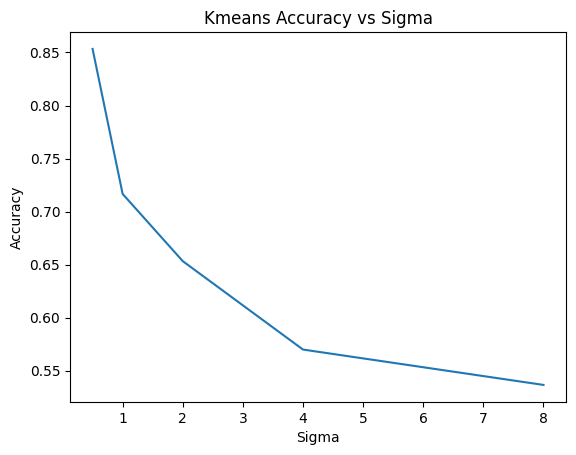

In [1206]:
sns.lineplot(x=plot_loss[:,0], y=plot_loss[:,1])
plt.title("Kmeans Loss vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Loss")
plt.show()
sns.lineplot(x=plot_accuracy[:,0], y=plot_accuracy[:,1])
plt.title("Kmeans Accuracy vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Accuracy")

[(0.5, 0.630771768897619), (1, 0.730360476985826), (2, 0.9908266617752118), (4, 1.4084668244972212), (8, 1.7800754897226825)]
[(0.5, 0.8033333333333333), (1, 0.74), (2, 0.6233333333333333), (4, 0.5533333333333333), (8, 0.5533333333333333)]


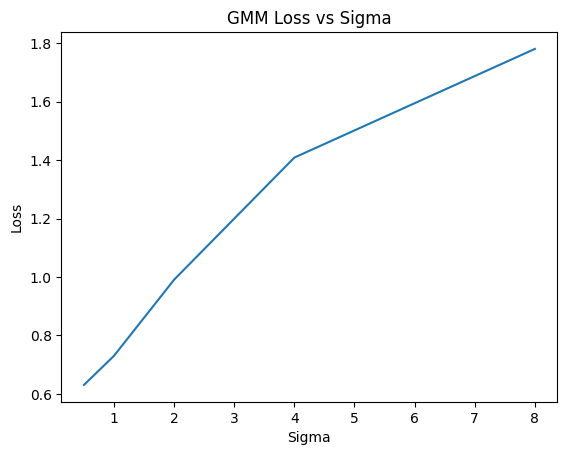

Text(0, 0.5, 'Accuracy')

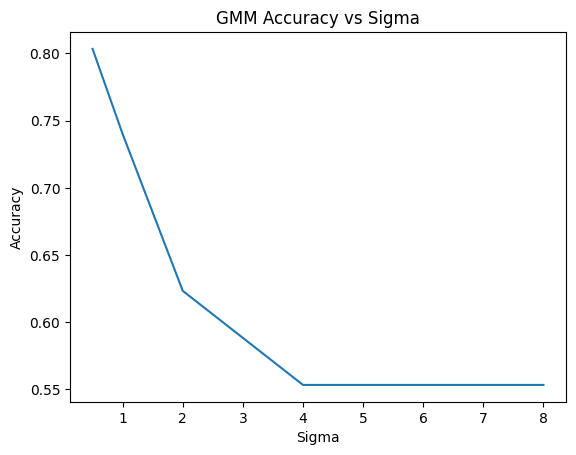

In [1219]:
plot_loss = []
plot_accuracy = []
for sigma in sigmas:
    model_eval = []
    for _ in range(10):
        try:
            data, clusters, labels, means = generate_data(sigma)
            gmm = GMM(3, data) 
            # gmm.train(20)
            gmm.train(10)
            model_eval.append((gmm.get_loss(means), get_gmm_accuracy(gmm, means)))
        except:
            continue
    plot_loss.append((sigma, max(model_eval, key = lambda x: x[1])[0]))
    plot_accuracy.append((sigma, max(model_eval, key = lambda x: x[1])[1]))
    # clustered_data = [[point.point[0], point.point[1], point.label] for point in gmm.points]
    # np_clustered = np.array(clustered_data)
    # clustered_pd = pd.DataFrame(np_clustered, columns=["x", "y", "label"])
    # sns.scatterplot(data=clustered_pd, x="x", y="y", hue="label")
    # plt.title(f"GMM with sigma={sigma}") 
    # plt.show()

print(plot_loss)
print(plot_accuracy)
plot_loss = np.array(plot_loss)
plot_accuracy = np.array(plot_accuracy)

sns.lineplot(x=plot_loss[:,0], y=plot_loss[:,1])
plt.title("GMM Loss vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Loss")
plt.show()
sns.lineplot(x=plot_accuracy[:,0], y=plot_accuracy[:,1])
plt.title("GMM Accuracy vs Sigma")
plt.xlabel("Sigma")
plt.ylabel("Accuracy")